In [1]:
import os,sys
source_file_path=os.environ['HOME']+'/work/'+'ResNet-50/'
os.chdir(source_file_path)
print(source_file_path)

/home/ma-user/work/ResNet-50/


In [2]:
!pip install mindvision
!pip install opencv-python install "opencv-python-headless<4.3"

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple

[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple

[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
batch_size = 18                             # 批量大小
image_size = 224                            # 训练图像空间大小
num_epochs = 10                             # 训练周期数
# lr = 0.001                                  # 学习率
momentum = 0.9                              # momentum
workers = 12                                 # 并行线程个数

In [5]:
## import mindspore as ms
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as vision
import mindspore.dataset.transforms.c_transforms as c_transforms
import mindspore.dataset.vision.c_transforms as c_vision
import mindspore as ms
from mindspore import Model, Tensor, context, load_checkpoint, load_param_into_net


# 数据集目录路径
data_path_train = "./dataset_food1/train/"
data_path_val = "./dataset_food1/val/"

# 创建训练数据集

def create_dataset_canidae(dataset_path, batch_size,repeat_num,workers):
    """数据加载"""
    dataset = ds.ImageFolderDataset(dataset_path,
                                     num_parallel_workers=workers,
                                     shuffle=True,)

    # 数据增强操作
    mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
    std = [0.229 * 255, 0.224 * 255, 0.225 * 255]
    image_size = [224, 224]
    # if usage == "train":
    #     # Define map operations for training dataset
    #     trans = [
    #         vision.RandomCropDecodeResize(size=image_size, scale=(0.08, 1.0), ratio=(0.75, 1.333)),
    #         vision.RandomHorizontalFlip(prob=0.5),
    #         vision.Normalize(mean=mean, std=std),
    #         vision.HWC2CHW()
    #     ]
    # else:
    #     # Define map operations for inference dataset
    trans = [
            c_vision.Decode(),
            c_vision.Resize(image_size),
            c_vision.Normalize(mean=mean, std=std),
            c_vision.HWC2CHW()
        ]


    # # 数据映射操作
    # data_set = data_set.map(
    #     operations=trans,
    #     input_columns='image',
    #     num_parallel_workers=workers)


    # 批量操作
    type_cast_op = c_transforms.TypeCast(ms.int32)
    dataset = dataset.map(operations=trans, input_columns="image")
    dataset = dataset.map(operations=type_cast_op, input_columns="label")
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.repeat(repeat_num)

    return dataset


dataset_train = create_dataset_canidae(data_path_train, batch_size=18, repeat_num=1,workers=12)
step_size_train = dataset_train.get_dataset_size()

dataset_val = create_dataset_canidae(data_path_val, batch_size=18, repeat_num=1,workers=12)
step_size_val = dataset_val.get_dataset_size()

### 数据集可视化

从`mindspore.dataset.ImageFolderDataset`接口中加载的训练数据集返回值为字典，用户可通过 `create_dict_iterator` 接口创建数据迭代器，使用 `next` 迭代访问数据集。本章中 `batch_size` 设为18，所以使用 `next` 一次可获取18个图像及标签数据。

In [6]:
data = next(dataset_train.create_dict_iterator())
images = data["image"]
labels = data["label"]

print("Tensor of image", images.shape)
print("Labels:", labels)

Tensor of image (18, 3, 224, 224)
Labels: [5 2 5 1 1 2 7 8 8 6 3 0 8 9 5 6 9 3]


对获取到的图像及标签数据进行可视化，标题为图像对应的label名称。

5
2
5
1


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


1
2


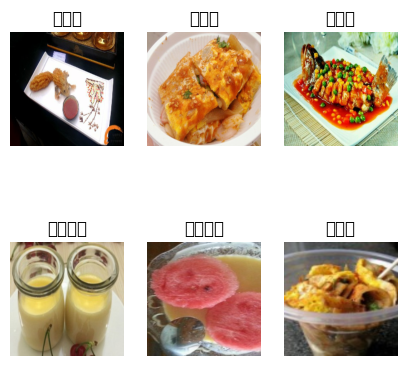

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from pylab import mpl
import cv2
# 设置显示中文字体
mpl.rcParams["font.sans-serif"] = ["SimHei"]
# class_name对应label，按文件夹字符串从小到大的顺序标记label
class_name = {0:"冰激凌",1:"鸡蛋布丁",2:"烤冷面",3:"芒果班戟",4:"三明治",5:"松鼠鱼",6:"甜甜圈",7:"土豆泥",8:"小米粥",9:"玉米饼",}
plt.figure(figsize=(5, 5))
for i in range(6):
    # 获取图像及其对应的label
    data_image = images[i].asnumpy()
    data_label = labels[i]
    print(data_label)
    # 处理图像供展示使用
    data_image = np.transpose(data_image, (1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    data_image = std * data_image + mean
    data_image = np.clip(data_image, 0, 1)
    # 显示图像
    plt.subplot(2, 3, i+1)
    plt.imshow(data_image)
    plt.title(class_name[int(labels[i].asnumpy())])
    plt.axis("off")

plt.show()

## 训练模型

本章使用ResNet50模型进行训练。搭建好模型框架后，通过将`pretrained`参数设置为True来下载[ResNet50的预训练模型](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/models/application/resnet50_224_new.ckpt)并将权重参数加载到网络中。

### 构建Resnet50网络

In [8]:
from typing import Type, Union, List, Optional
import mindspore
from mindspore import nn, train
from mindspore.common.initializer import Normal


weight_init = Normal(mean=0, sigma=0.02)
gamma_init = Normal(mean=1, sigma=0.02)

In [9]:

from typing import Type, Union, List, Optional
from mindvision.classification.models.blocks import ConvNormActivation
from mindspore import nn


class ResidualBlockBase(nn.Cell):
    expansion: int = 1  # 最后一个卷积核数量与第一个卷积核数量相等

    def __init__(self, in_channel: int, out_channel: int,
                 stride: int = 1, norm: Optional[nn.Cell] = None,
                 down_sample: Optional[nn.Cell] = None) -> None:
        super(ResidualBlockBase, self).__init__()
        if not norm:
            norm = nn.BatchNorm2d

        self.conv1 = ConvNormActivation(in_channel, out_channel,
                                        kernel_size=3, stride=stride, norm=norm)
        self.conv2 = ConvNormActivation(out_channel, out_channel,
                                        kernel_size=3, norm=norm, activation=None)
        self.relu = nn.ReLU()
        self.down_sample = down_sample

    def construct(self, x):
        """ResidualBlockBase construct."""
        identity = x  # shortcuts分支

        out = self.conv1(x)  # 主分支第一层：3*3卷积层
        out = self.conv2(out)  # 主分支第二层：3*3卷积层

        if self.down_sample:
            identity = self.down_sample(x)
        out += identity  # 输出为主分支与shortcuts之和
        out = self.relu(out)

        return out


In [10]:

class ResidualBlock(nn.Cell):
    expansion = 4  # 最后一个卷积核的数量是第一个卷积核数量的4倍

    def __init__(self, in_channel: int, out_channel: int,
                 stride: int = 1, norm: Optional[nn.Cell] = None,
                 down_sample: Optional[nn.Cell] = None) -> None:
        super(ResidualBlock, self).__init__()
        if not norm:
            norm = nn.BatchNorm2d

        self.conv1 = ConvNormActivation(in_channel, out_channel,
                                        kernel_size=1, norm=norm)
        self.conv2 = ConvNormActivation(out_channel, out_channel,
                                        kernel_size=3, stride=stride, norm=norm)
        self.conv3 = ConvNormActivation(out_channel, out_channel * self.expansion,
                                        kernel_size=1, norm=norm, activation=None)
        self.relu = nn.ReLU()
        self.down_sample = down_sample

    def construct(self, x):
        identity = x  # shortscuts分支

        out = self.conv1(x)  # 主分支第一层：1*1卷积层
        out = self.conv2(out)  # 主分支第二层：3*3卷积层
        out = self.conv3(out)  # 主分支第三层：1*1卷积层

        if self.down_sample:
            identity = self.down_sample(x)

        out += identity  # 输出为主分支与shortcuts之和
        out = self.relu(out)

        return out


In [11]:

def make_layer(last_out_channel, block: Type[Union[ResidualBlockBase, ResidualBlock]],
               channel: int, block_nums: int, stride: int = 1):
    down_sample = None  # shortcuts分支

    if stride != 1 or last_out_channel != channel * block.expansion:
        down_sample = ConvNormActivation(last_out_channel, channel * block.expansion,
                                         kernel_size=1, stride=stride, norm=nn.BatchNorm2d, activation=None)

    layers = []
    layers.append(block(last_out_channel, channel, stride=stride, down_sample=down_sample, norm=nn.BatchNorm2d))

    in_channel = channel * block.expansion
    # 堆叠残差网络
    for _ in range(1, block_nums):
        layers.append(block(in_channel, channel, norm=nn.BatchNorm2d))

    return nn.SequentialCell(layers)


In [12]:

from mindvision.classification.models.classifiers import BaseClassifier
from mindvision.classification.models.head import DenseHead
from mindvision.classification.models.neck import GlobalAvgPooling
from mindvision.classification.utils.model_urls import model_urls
from mindvision.utils.load_pretrained_model import LoadPretrainedModel


class ResNet(nn.Cell):
    def __init__(self, block: Type[Union[ResidualBlockBase, ResidualBlock]],
                 layer_nums: List[int], norm: Optional[nn.Cell] = None) -> None:
        super(ResNet, self).__init__()
        if not norm:
            norm = nn.BatchNorm2d
        # 第一个卷积层，输入channel为3（彩色图像），输出channel为64
        self.conv1 = ConvNormActivation(3, 64, kernel_size=7, stride=2, norm=norm)
        # 最大池化层，缩小图片的尺寸
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode='same')
        # 各个残差网络结构块定义，
        self.layer1 = make_layer(64, block, 64, layer_nums[0])
        self.layer2 = make_layer(64 * block.expansion, block, 128, layer_nums[1], stride=2)
        self.layer3 = make_layer(128 * block.expansion, block, 256, layer_nums[2], stride=2)
        self.layer4 = make_layer(256 * block.expansion, block, 512, layer_nums[3], stride=2)

    def construct(self, x):
        x = self.conv1(x)
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        return x


def _resnet(arch: str, block: Type[Union[ResidualBlockBase, ResidualBlock]],
            layers: List[int], num_classes: int, pretrained: bool, input_channel: int):
    backbone = ResNet(block, layers)
    neck = GlobalAvgPooling()  # 平均池化层
    head = DenseHead(input_channel=input_channel, num_classes=num_classes)  # 全连接层
    model = BaseClassifier(backbone, neck, head)  # 将backbone层、neck层和head层连接起来

    if pretrained:
        # 下载并加载预训练模型
        LoadPretrainedModel(model, model_urls[arch]).run()

    return model


def resnet50(num_classes: int = 1000, pretrained: bool = False):
    "ResNet50模型"
    return _resnet("resnet50", ResidualBlock, [3, 4, 6, 3], num_classes, pretrained, 2048)

# 定义全连接层
class DenseHead(nn.Cell):
    def __init__(self, input_channel, num_classes):
        super(DenseHead, self).__init__()

        self.dense = nn.Dense(input_channel, num_classes)
        self.dropout = nn.Dropout(keep_prob=0.5)

    def construct(self, x):
        x = self.dropout(x)
        return self.dense(x)


### 模型微调

由于ResNet50中的预训练模型是针对ImageNet数据集中的1000个类别进行分类的，在本章只对狼和狗两个类别进行分类，所以需要重置预训练模型中的分类器，然后重新微调网络。

In [13]:

from mindspore.train import Model
from mindvision.engine.callback import ValAccMonitor,LossMonitor
from mindvision.classification.models.resnet import resnet101
context.set_context(mode=context.GRAPH_MODE, device_target="Ascend")

# 定义ResNet50网络
network = resnet101(pretrained=True)
    
# 全连接层输入层的大小
in_channel = network.head.dense.in_channels
head = DenseHead(input_channel=in_channel, num_classes=10)
# 重置全连接层
network.head = head
    
# 设置学习率
num_epochs = 50
step_size = step_size_train
lr = nn.cosine_decay_lr(min_lr=0.00001, max_lr=0.001, total_step=step_size * num_epochs,
                        step_per_epoch=step_size, decay_epoch=num_epochs)
# 定义优化器和损失函数
opt = nn.Momentum(params=network.trainable_params(), learning_rate=lr, momentum=0.9)
loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
# 实例化模型
model = Model(network, loss, opt, metrics={"Accuracy": nn.Accuracy()})
# 模型训练
# model.train(num_epochs, dataset_train, callbacks=[ValAccMonitor(model, dataset_val, num_epochs)])
model.train(train_dataset=dataset_train, epoch=num_epochs,
            callbacks=[LossMonitor(lr_init=lr, per_print_times=100)])


Epoch:[  0/ 50], step:[  175/  175], loss:[0.341/0.341], time:71008.058 ms, lr:0.00100
Epoch time: 71274.669 ms, per step time: 407.284 ms, avg loss: 0.341
Epoch:[  1/ 50], step:[  175/  175], loss:[0.100/0.100], time:9458.869 ms, lr:0.00100
Epoch time: 9474.692 ms, per step time: 54.141 ms, avg loss: 0.100
Epoch:[  2/ 50], step:[  175/  175], loss:[0.055/0.055], time:9467.311 ms, lr:0.00100
Epoch time: 9492.455 ms, per step time: 54.243 ms, avg loss: 0.055
Epoch:[  3/ 50], step:[  175/  175], loss:[0.138/0.138], time:9449.352 ms, lr:0.00099
Epoch time: 9461.946 ms, per step time: 54.068 ms, avg loss: 0.138
Epoch:[  4/ 50], step:[  175/  175], loss:[0.101/0.101], time:9453.662 ms, lr:0.00098
Epoch time: 9462.531 ms, per step time: 54.072 ms, avg loss: 0.101
Epoch:[  5/ 50], step:[  175/  175], loss:[0.022/0.022], time:9502.758 ms, lr:0.00098
Epoch time: 9511.058 ms, per step time: 54.349 ms, avg loss: 0.022
Epoch:[  6/ 50], step:[  175/  175], loss:[0.012/0.012], time:9445.773 ms, lr:0

In [15]:
ms.save_checkpoint(network, "resnet101.ckpt")

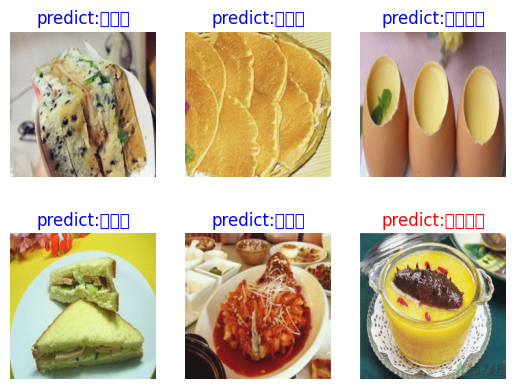

In [16]:

import matplotlib.pyplot as plt
from mindspore import Tensor
# from mindspore import load_checkpoint, load_param_into_net


class_name = {0:"冰激凌",1:"鸡蛋布丁",2:"烤冷面",3:"芒果班戟",4:"三明治",5:"松鼠鱼",6:"甜甜圈",7:"土豆泥",8:"小米粥",9:"玉米饼",}

def visualize_model(best_ckpt_path, val_ds):
    num_class = 10  # 对狼和狗图像进行二分类
    net = resnet101(num_class)
    # 加载模型参数
    param_dict = load_checkpoint(best_ckpt_path)
    load_param_into_net(net, param_dict)
    model = Model(net)
    # 加载验证集的数据进行验证
    data = next(val_ds.create_dict_iterator())
    images = data["image"].asnumpy()
    labels = data["label"].asnumpy()
    # 预测图像类别
    output = model.predict(Tensor(data['image']))
    pred = np.argmax(output.asnumpy(), axis=1)

    # 显示图像及图像的预测值
    plt.figure()
    for i in range(1, 7):
        plt.subplot(2, 3, i)
        # 若预测正确，显示为蓝色；若预测错误，显示为红色
        color = 'blue' if pred[i - 1] == labels[i - 1] else 'red'
        plt.title('predict:{}'.format(class_name[pred[i - 1]]), color=color)
        picture_show = np.transpose(images[i - 1], (1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        picture_show = std * picture_show + mean
        picture_show = np.clip(picture_show, 0, 1)
        plt.imshow(picture_show)
        plt.axis('off')

    plt.show()

# 使用测试数据集进行验证
visualize_model('resnet101.ckpt', dataset_val)


#### 训练和评估

训练并评估网络，且在训练完成后，保存评估精度最高的ckpt文件(resnet50-best.ckpt)到当前路径的/BestCheckpoint下，保存路径和ckpt文件名可自行调整。

In [19]:
class_name = {0:"冰激凌",1:"鸡蛋布丁",2:"烤冷面",3:"芒果班戟",4:"三明治",5:"松鼠鱼",6:"甜甜圈",7:"土豆泥",8:"小米粥",9:"玉米饼",}
def _crop_center(img, cropx, cropy):
    y, x, _ = img.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return img[starty:starty + cropy, startx:startx + cropx, :]


def _normalize(img, mean, std):
    # This method is borrowed from:
    #   https://github.com/open-mmlab/mmcv/blob/master/mmcv/image/photometric.py
    assert img.dtype != np.uint8
    mean = np.float64(mean.reshape(1, -1))
    stdinv = 1 / np.float64(std.reshape(1, -1))
    cv2.cvtColor(img, cv2.COLOR_BGR2RGB, img)
    cv2.subtract(img, mean, img)
    cv2.multiply(img, stdinv, img)
    return img


def data_preprocess(img_path):
    img = cv2.imread(img_path, 1)
    img = cv2.resize(img, (256, 256))
    img = _crop_center(img, 224, 224)
    mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
    std = [0.229 * 255, 0.224 * 255, 0.225 * 255]
    img = _normalize(img.astype(np.float32), np.asarray(mean), np.asarray(std))
    img = img.transpose(2, 0, 1)

    return img


def resnet50_predict(class_num):
    num_class = class_num
    local_data_path = '/home/ma-user/work/ResNet-50/dataset_food/test'
    local_ckpt_path = r'/home/ma-user/work/ResNet-50/resnet101.ckpt'

    # set graph mode and parallel mode
    context.set_context(mode=context.GRAPH_MODE, device_target='Ascend', save_graphs=False)

    
    # load checkpoint into net
    net = resnet101(num_class)
    param_dict = load_checkpoint(local_ckpt_path)
    load_param_into_net(net, param_dict)
    net.set_train(False)

    # preprocess the image
    images = os.listdir(local_data_path)
    images.sort(key=lambda x:int(x.split('.')[0].split('_')[1]))
    label_dict = []
    for image in images:
        print(image)
        img = data_preprocess(os.path.join(local_data_path, image))
        # predict model
        res = net(Tensor(img.reshape((1, 3, 224, 224)), mindspore.float32)).asnumpy()
        predict_label = int(res[0].argmax())
        print(class_name[predict_label])
        label_dict.append(predict_label)
    with open('/home/ma-user/work/ResNet-50/result1.txt','w') as t:
        for a in label_dict:
            t.write(str(a)+'\n')
    t.close()

In [ ]:
if __name__ == '__main__':
    resnet50_predict(10)
    print('ResNet50 prediction success!')

img_0.jpg


In [1]:
import moxing as mox
mox.file.copy('/home/ma-user/work/ResNet-50/best_food_0.968.ckpt', 'obs://huxian456/best_food.ckpt')

INFO:root:Using MoXing-v2.0.1.rc0.ffd1c0c8-ffd1c0c8
INFO:root:Using OBS-Python-SDK-3.20.9.1


In [2]:
import moxing as mox
mox.file.copy('/home/ma-user/work/ResNet-50/resnet50_classification_food.ipynb', 'obs://huxian456/classification_food.ipynb')

In [ ]:
import moxing as mox
mox.file.copy('/home/ma-user/work/ResNet-50/best_food_0.968.ckpt', 'obs://huxian456/best_food.ckpt')